In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
d_name = "espresso_data"

In [3]:
def get_curves(dir_name):
    all_bt = []
    all_et = []
    all_burner = []
    
    file_names = os.listdir(dir_name)
    
    for i,f_name in enumerate(file_names):
        bt_curve = extract_curve(f_name,dir_name,"'temp2':")
        et_curve = extract_curve(f_name,dir_name,"'temp1':")
        burner_curve = extract_burner(f_name,dir_name)
        
        if not bt_curve == []:
            all_bt.append(bt_curve)
        if not et_curve == []:
            all_et.append(et_curve)
        if not burner_curve == []:
            all_burner.append(burner_curve)
            
    return all_bt,all_et,all_burner

def extract_burner(f_name,dir_name):
    events = []
    events_types = []
    events_value = []
    burner_curve = []
    
    with open(dir_name+"/"+f_name,"r") as f:
        lines = [
        line.strip("\n").split(" ") + [index + 1]
        for index, line in enumerate(f.readlines())
        ]
        if len(lines)==0:
            return []
        lines = lines[0]
        
        charge_idx = get_charge(lines)
        drop_index = int(float(lines[lines.index("'DROP_time':")+1][:-1]))
        
        events_idx = lines.index("'specialevents':")
        event_types_idx = lines.index("'specialeventstype':")
        events_value_idx = lines.index("'specialeventsvalue':")
        n_events = event_types_idx - events_idx - 1
        for i in range(events_idx+1,event_types_idx):
            e = lines[i][:-1]
            if i == events_idx + 1:
                e = e[1:]
            elif i == event_types_idx - 1:
                e = e[:-1]

            events.append(float(e))

        for i in range(event_types_idx+1,event_types_idx+1+n_events):
            e = lines[i][:-1]
            if i == event_types_idx+1:
                e = e[1:]
            elif i == event_types_idx + n_events:
                e = e[:-1]

            events_types.append(int(e))
        
        for i in range(events_value_idx+1,events_value_idx+1+n_events):
            e = lines[i][:-1]
            if i == events_value_idx+1:
                e = e[1:]
            elif i == events_value_idx + n_events:
                e = e[:-1]
            
            events_value.append(float(e))
            
    for i,e in  enumerate(events_value):
        if(events_types[i]==3):
                if i == len(events)-1:
                    while len(burner_curve)<=drop_index:
                        burner_curve.append(e)
                else:
                    for j in range(int(events[i]-(0 if i==0 else events[i-1]))):
                        if j + (0 if i==0 else events[i-1]) >= charge_idx:
                            burner_curve.append(e)
    return burner_curve   
            
def extract_curve(f_name,dir_name,curve_name):
    curve = []
    with open(dir_name+"/"+f_name,"r") as f:
            lines = [
            line.strip("\n").split(" ") + [index + 1]
            for index, line in enumerate(f.readlines())
            ]
            if len(lines)==0:
                return []
            lines = lines[0]

            #calculate indexes of CHARGE and DROP with regard to reading points, to extract temp readings only during roast
            charge_index = get_charge(lines)
            drop_index = int(float(lines[lines.index("'DROP_time':")+1][:-1]))+charge_index
            
            #shift indexes to correspond to proper place in the file
            curve_index = lines.index(curve_name)
            charge_index += curve_index+1
            drop_index += curve_index+1
            
            current_index = charge_index
            while current_index <= drop_index:
                curve.append(float(lines[current_index][:-1]))
                current_index += 1
    
    #mapping to get rid 
    return curve
        
def get_charge(lines):
    # find TP info to derive CHARGE index
    tp_info_index = lines.index("'TP_idx':")
    TP_idx = lines[tp_info_index+1]
    TP_time = lines[tp_info_index+3]
    
    #get rid of coma and cast to int
    TP_idx = int(float(TP_idx[:-1]))
    TP_time = int(float(TP_time[:-1]))
    
    # CHARGE IS TP_time seconds before TP_idx
    # could include time_step info as we assume that each step is 1s which sometimes might not be the case
    CHARGE_idx = TP_idx - TP_time
    
    return CHARGE_idx
        

In [7]:
bt_list,et_list,burner_list = get_curves(d_name)

data = []
for i in range(len(bt_list)):
    triple_curve = [bt_list[i],et_list[i]]#,burner_list[i]]
    #triple_curve = bt_list[i]
    triple_curve = [list(x) for x in zip(*triple_curve)]
    data.append(triple_curve)


KeyboardInterrupt: 

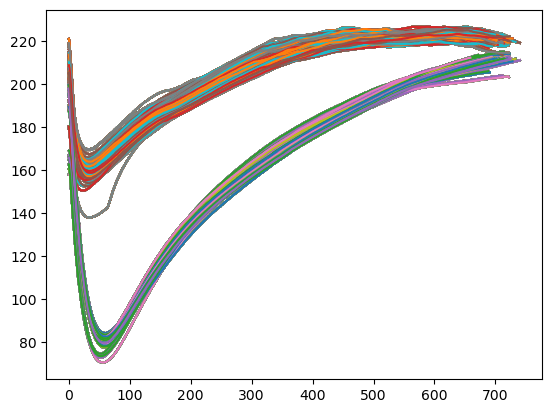

In [133]:

for i in (range(len(data))):
    for c in data:
        plt.plot(c)

In [ ]:
input_sequence_length = 60
output_sequence_length = 120

# Assuming you have data in the format: [bean_temperature, air_temperature]

# Modify data preparation
X_data = []
y_data = []

for curve in data:
    for i in range(len(curve) - input_sequence_length - output_sequence_length + 1):
        X_data.append(curve[i:i+input_sequence_length][:])  # Use both bean and air temperatures as input
        y_data.append(curve[i+input_sequence_length:i+input_sequence_length+output_sequence_length][:])  # Predict only bean temperature

X_data = np.array(X_data)
y_data = np.array(y_data)

scaler = MinMaxScaler()
X_data_scaled = scaler.fit_transform(X_data.reshape(-1, 2)).reshape(X_data.shape)  # Use 2 features for scaling
y_data_scaled = scaler.transform(y_data.reshape(-1, 2)).reshape(y_data.shape)[:,:,0]
# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(units=50, activation='relu', input_shape=(input_sequence_length, 2), return_sequences=True),
    layers.LSTM(units=50, activation='relu'),
    layers.Dense(units=output_sequence_length)
])
# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mse')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_data_scaled, y_data_scaled, epochs=40, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/40
2485/2485 [==============================] - 61s 24ms/step - loss: 0.0061 - val_loss: 1.2455e-04
Epoch 2/40
2485/2485 [==============================] - 59s 24ms/step - loss: 4.0905e-05 - val_loss: 5.5861e-05
Epoch 3/40
2485/2485 [==============================] - 60s 24ms/step - loss: 3.0823e-05 - val_loss: 8.3730e-05
Epoch 4/40
2485/2485 [==============================] - 60s 24ms/step - loss: 2.7462e-05 - val_loss: 4.4385e-05
Epoch 5/40
2485/2485 [==============================] - 61s 25ms/step - loss: 2.5350e-05 - val_loss: 4.8997e-05
Epoch 6/40
2485/2485 [==============================] - 67s 27ms/step - loss: 2.2192e-05 - val_loss: 3.4951e-05
Epoch 7/40
2485/2485 [==============================] - 68s 27ms/step - loss: 2.1195e-05 - val_loss: 4.6217e-05
Epoch 8/40
2485/2485 [==============================] - 65s 26ms/step - loss: 1.9091e-05 - val_loss: 6.9172e-05
Epoch 9/40
  24/2485 [..............................] - ETA: 56s - loss: 1.8642e-05

1/1 [==============================] - 0s 17ms/step
Predicted Sequence:
[159.0172  159.17323 159.27048 159.5583  159.77621 159.82942 160.22618
 160.24316 160.46558 160.86998 160.92104 161.0975  161.39923 161.6495
 161.84721 162.05467 162.12263 162.26804 162.60384 162.71272 162.97092
 163.23537 163.45084 163.59062 163.758   163.91786 164.14586 164.34369
 164.61896 164.79707 165.07822 165.04338 165.27783 165.48683 165.6332
 166.0001  166.08441 166.1998  166.55063 166.64508 166.87247 167.0904
 167.26155 167.57384 167.49968 167.70212 168.06804 168.18454 168.22025
 168.42815 168.80199 168.94116 169.08395 169.40352 169.50531 169.66621
 169.92883 170.09575 170.30635 170.37419 170.48232 170.68886 170.87581
 171.00679 171.15076 171.4702  171.54953 171.75873 171.92647 172.19354
 172.23532 172.54214 172.5801  172.7612  172.95174 173.11017 173.25725
 173.6285  173.69727 173.64522 173.9107  174.21597 174.48643 174.50908
 174.69736 174.93135 174.97903 175.1835  175.44177 175.67627 175.59114
 175.842

<Axes: >

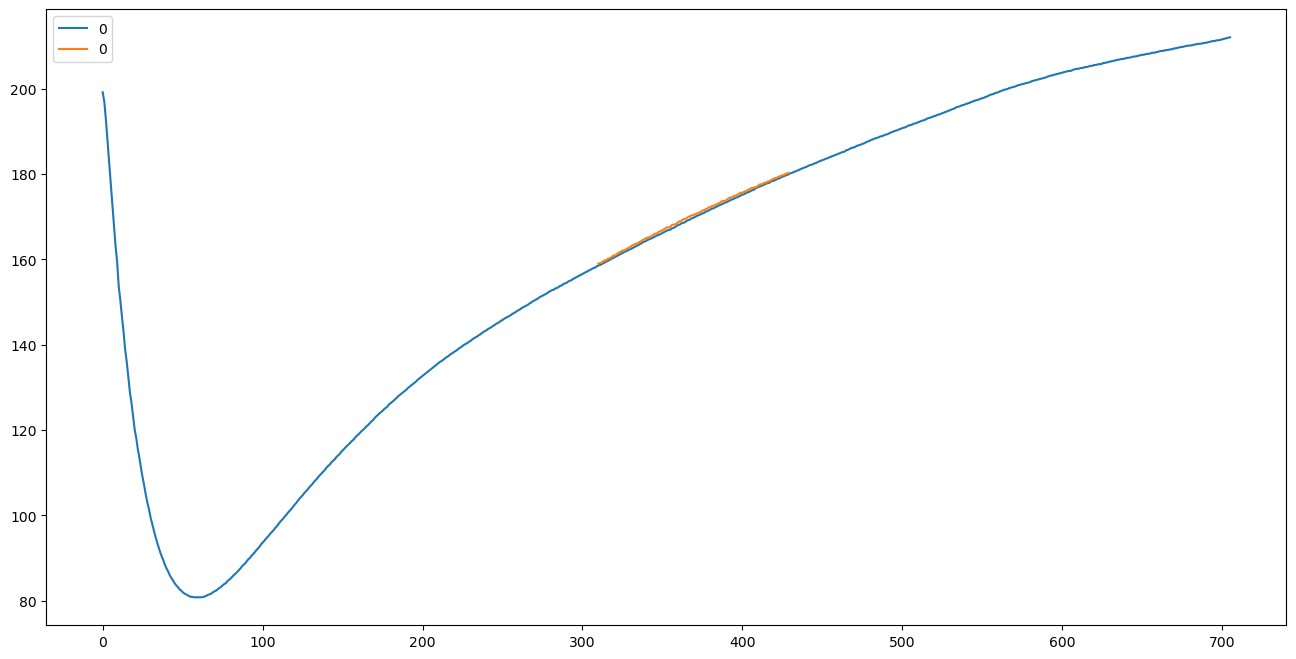

In [119]:
curve_id = 5
offset = 250
X_new = data[curve_id][offset:offset+input_sequence_length]
X_new = np.array(X_new)
X_new = X_new.reshape(1,60)
X_new_scaled = scaler.transform(X_new.reshape(-1, 1)).reshape(X_new.shape)
predictions_scaled = model.predict(X_new_scaled)

# Inverse transform the predictions to the original scale
predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).reshape(predictions_scaled.shape)

# Print the predicted sequence
print("Predicted Sequence:")
print(predictions.squeeze())

df = pd.DataFrame(data[curve_id])
pred_index = np.arange(offset+input_sequence_length,input_sequence_length+len(predictions[0])+offset,1)
pred_df = pd.DataFrame(data=predictions[0],index=pred_index)
#Plot predictions vs real curve
ax = df.plot(figsize=(16,8))
pred_df.plot(ax=ax)

(0.0, 0.0002)

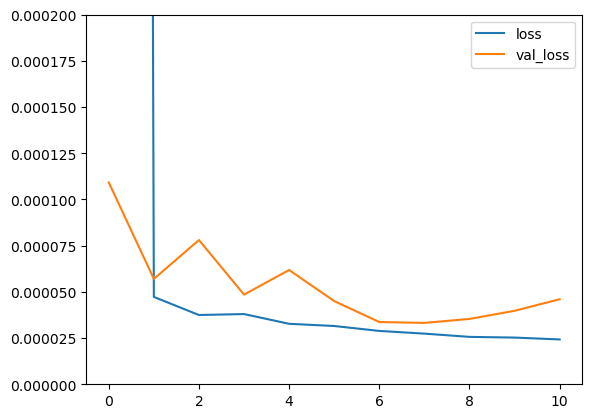

In [110]:
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.ylim((0,0.0002))